# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import os
import sys
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
try:
    BASEPATH = os.path.dirname(os.path.realpath(__file__))
    data_path = os.path.join(BASEPATH, "..", "..", "data")
except NameError:
    if os.path.exists("data"):
        BASEPATH = "."
        data_path = os.path.join(BASEPATH, "data")
    else:
        BASEPATH = os.getcwd()
        data_path = os.path.join(BASEPATH, "..", "..", "data")

In [3]:
sys.path.append(os.path.join(BASEPATH, "..", "..", "src"))
from mltier1 import Field, Q_0, parallel_process, describe

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
from IPython.display import clear_output

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

### Area limits

In [9]:
margin_ra = 0.1
margin_dec = 0.1

In [10]:
# # Test samples P005p28.fits
# dec_down = 27.206
# dec_up = 29.8
# ra_down = 4.025
# ra_up = 7.08

# # Test samples LoTSS_DR2_RA0INNER_v0.9.srl
# dec_down = 27.7
# dec_up = 34.
# ra_down = 6.
# ra_up = 20.5

# Test samples LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits
dec_down = 22.25
dec_up = 32.
ra_down = 0.
ra_up = 20.5

In [11]:
field = Field(ra_down, ra_up, dec_down, dec_up)

In [12]:
field_optical = Field(
    ra_down - margin_ra, 
    ra_up + margin_ra, 
    dec_down - margin_dec, 
    dec_up + margin_dec)

## Load data

In [13]:
combined_all = Table.read(os.path.join(data_path, "samples", "test_combined.fits"))

In [14]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
#lofar_all = Table.read(os.path.join(data_path, "samples", "P005p28.fits"))
lofar_all = Table.read(os.path.join(data_path, "samples", "LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits"))

In [15]:
np.array(combined_all.colnames)

array(['RA', 'DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2'],
      dtype='<U12')

In [16]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID'], dtype='<U12')

### Filter catalogues

In [43]:
lofar = field.filter_catalogue(
    lofar_all[(lofar_all["Maj"] < 15.0)], colnames=("RA", "DEC")
)

In [44]:
combined = field.filter_catalogue(combined_all, colnames=("RA", "DEC"))

In [45]:
print(len(lofar_all), len(lofar))

516404 91484


In [46]:
print(len(combined_all), len(combined))

117758023 14146049


### Sky coordinates

In [47]:
coords_combined = SkyCoord(
    combined["RA"], combined["DEC"], unit=(u.deg, u.deg), frame="icrs"
)

In [48]:
coords_lofar = SkyCoord(lofar["RA"], lofar["DEC"], unit=(u.deg, u.deg), frame="icrs")

### Summary of galaxy types in the combined catalogue

In [49]:
combined_legacy = (
    ~np.isnan(combined["MAG_R"])
    & ~np.isnan(combined["MAG_W1"])
    & ~np.isnan(combined["MAG_W2"])
)
np.sum(combined_legacy)  # Matches

12469235

In [50]:
combined_matched = ~np.isnan(combined["MAG_R"]) & (combined["UNWISE_OBJID"] != "N/A")
np.sum(combined_matched)

4314528

In [51]:
combined_legacy_only = ~np.isnan(combined["MAG_R"]) & (
    combined["UNWISE_OBJID"] == "N/A"
)
np.sum(combined_legacy_only)  # Only Legacy

8154707

In [52]:
print(np.sum(combined_legacy))
print(np.sum(combined_matched) + np.sum(combined_legacy_only))

12469235
12469235


In [53]:
combined_wise = np.isnan(combined["MAG_R"]) & (~np.isnan(combined["MAG_W1"]))
np.sum(combined_wise)  # Only WISE

1478875

In [54]:
combined_wise2 = np.isnan(combined["MAG_R"]) & np.isnan(combined["MAG_W1"])
np.sum(combined_wise2)  # Only WISE2

197939

In [55]:
print(len(combined))
print(np.sum(combined_legacy) + np.sum(combined_wise) + np.sum(combined_wise2))

14146049
14146049


## $Q_0$ dependence on the radius

We will iterate 10 times for each radius.

In [56]:
n_iter = 10

In [57]:
rads = list(range(1,26))

### r-band

In [58]:
q_0_comp_r = Q_0(coords_lofar, coords_combined[combined_legacy], field)

In [ ]:
q_0_rad_r = []
q_0_rad_r_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        try:
            out = q_0_comp_r(radius=radius)
        except ZeroDivisionError:
            continue
        else:
            q_0_rad_aux.append(out)
    q_0_rad_r.append(np.mean(q_0_rad_aux))
    q_0_rad_r_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.46474 +/- 0.00019 [0.46441 0.46504]
 2 0.62428 +/- 0.00031 [0.62358 0.62483]
 3 0.66658 +/- 0.00041 [0.66614 0.66731]
 4 0.68808 +/- 0.00069 [0.68645 0.68903]
 5 0.69852 +/- 0.00111 [0.69682 0.70005]
 6 0.70438 +/- 0.00080 [0.70317 0.70592]
 7 0.70954 +/- 0.00112 [0.70771 0.71118]
 8 0.71578 +/- 0.00114 [0.71388 0.71693]
 9 0.71841 +/- 0.00138 [0.71605 0.72083]
10 0.72176 +/- 0.00130 [0.71891 0.72348]
11 0.72609 +/- 0.00301 [0.72038 0.73322]
12 0.72846 +/- 0.00159 [0.72581 0.73049]
13 0.72863 +/- 0.00345 [0.72041 0.73237]
14 0.73282 +/- 0.00468 [0.72377 0.73834]
15 0.73179 +/- 0.00437 [0.72322 0.73614]


(0, 1)

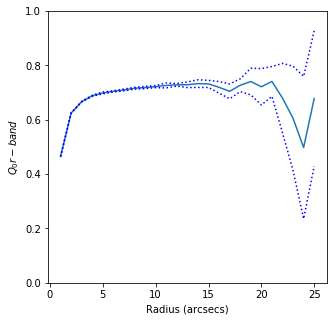

In [61]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_r)
plt.plot(rads, np.array(q_0_rad_r) + 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_r) - 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 r-band$")
plt.ylim([0, 1])

### W1-band

In [35]:
q_0_comp_w1 = Q_0(coords_lofar, coords_combined[combined_wise], field)

In [62]:
q_0_rad_w1 = []
q_0_rad_w1_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    q_0_rad_w1_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.05146 +/- 0.00013 [0.05128 0.05170]
 2 0.10559 +/- 0.00028 [0.10511 0.10611]
 3 0.15257 +/- 0.00034 [0.15204 0.15301]
 4 0.19160 +/- 0.00048 [0.19065 0.19249]
 5 0.21813 +/- 0.00045 [0.21727 0.21877]
 6 0.23492 +/- 0.00040 [0.23424 0.23562]
 7 0.24763 +/- 0.00085 [0.24620 0.24884]
 8 0.25827 +/- 0.00068 [0.25704 0.25922]
 9 0.26819 +/- 0.00053 [0.26717 0.26917]
10 0.27610 +/- 0.00101 [0.27445 0.27783]
11 0.28175 +/- 0.00140 [0.27971 0.28386]
12 0.28607 +/- 0.00109 [0.28445 0.28843]
13 0.28812 +/- 0.00083 [0.28653 0.28894]
14 0.28969 +/- 0.00164 [0.28642 0.29202]
15 0.29154 +/- 0.00144 [0.28907 0.29360]
16 0.29401 +/- 0.00127 [0.29154 0.29615]
17 0.29645 +/- 0.00182 [0.29189 0.29854]
18 0.29748 +/- 0.00142 [0.29487 0.29956]
19 0.30033 +/- 0.00175 [0.29757 0.30317]
20 0.29768 +/- 0.00266 [0.29330 0.30151]
21 0.29834 +/- 0.00202 [0.29547 0.30146]
22 0.29857 +/- 0.00273 [0.29328 0.30273]
23 0.29745 +/- 0.00207 [0.29417 0.30113]
24 0.29821 +/- 0.00247 [0.29385 0.30255]
25 0.29913 +/- 0

(0, 0.4)

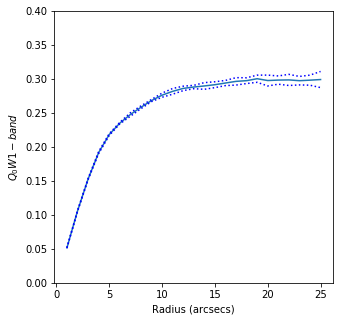

In [63]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w1)
plt.plot(rads, np.array(q_0_rad_w1) + 3 * np.array(q_0_rad_w1_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_w1) - 3 * np.array(q_0_rad_w1_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W1-band$")
plt.ylim([0, 0.4])

### W2-band

In [ ]:
q_0_comp_w2 = Q_0(coords_lofar, coords_combined[combined_wise2], field)

In [ ]:
q_0_rad_w2 = []
q_0_rad_w2_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w2(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w2.append(np.mean(q_0_rad_aux))
    q_0_rad_w2_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

(0, 0.08)

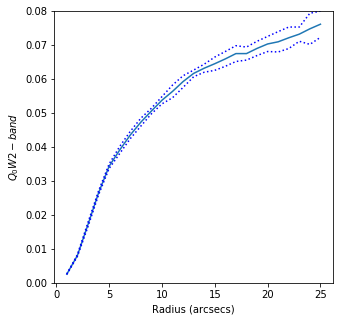

In [42]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w2)
plt.plot(rads, np.array(q_0_rad_w2) + 3 * np.array(q_0_rad_w2_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_w2) - 3 * np.array(q_0_rad_w2_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W2-band$")
plt.ylim([0, 0.08])